## General Steps
### 1.  Reading the Multispectral TIFF Images:

**Objective**: Extract the data from TIFF images captured by the drone.  

**Details**:  
Each TIFF image contains data from one of the four spectral bands:  
 - Green (G),  
 - Red (R),  
 - Red Edge (RE),  
 - Near-Infrared (NIR).  
 
Read these images and extract the pixel values for each band.  

### 2.  Aligning the Images and Correcting Distortion:

**Objective**: Ensure that the images from different spectral bands are perfectly aligned with each other and free from any distortions.  

**Details**:  
Due to possible movement of the drone or lens imperfections, the images might not be perfectly aligned. This step involves correcting any  
 such misalignment and distortion to ensure that the pixel data from each band corresponds to the same geographical location on the ground.  
 Techniques like image registration can be used here.


### 3. Calculating the NDVI for Each Pixel:
**`Objective`**:  
Compute the Normalized Difference Vegetation Index (NDVI) for each pixel using the extracted data.

**`Details`**: The NDVI is calculated using the following formula:

$$
NDVI = \frac{NIR - R}{NIR + R}
$$  
Where:  
NIR is the pixel value from the Near-Infrared band.  
R is the pixel value from the Red band.  
NDVI values range from -1 to +1, where higher values typically indicate healthier and more vigorous vegetation.


### Workflow  
`Read TIFF Images:`  
 Load the TIFF files corresponding to the Green, Red, Red Edge, and Near-Infrared bands.  

`Pre-process Images:`   
 Apply any necessary pre-processing steps like converting to grayscale if needed.  

`Align Images: `   
 Use techniques like feature matching and homography to align the images from different bands.  

`Calculate NDVI:`  
 Using the aligned Red and Near-Infrared band images, calculate the NDVI for each pixel.  
 
`Output Results:`  
 Save the NDVI image for further analysis or visualization.  


### 1.  Reading the Multispectral TIFF Images and Metadata:

In [1]:
import numpy as np
import cv2 as cv
from rasterio.plot import show
import subprocess
import json
import os
import glob

keys_to_extract = [
    'CalibratedOpticalCenterX', 'CalibratedOpticalCenterY', 
    'VignettingData', 'DewarpData', 'CalibratedHMatrix', 
    'BitsPerSample', 'BlackLevel', 'SensorGain', 
    'ExposureTime', 'SensorGainAdjustment', 'Irradiance',
    'VignettingCenter', 'VignettingPolynomial'
]

# get metadata from [XMP: drone-dji]
def get_metadata(file_path):
    try:
        result = subprocess.run(
            ['exiftool', '-j', file_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            check=True  # Raises CalledProcessError if command fails
        )
        metadata = json.loads(result.stdout)
        return metadata[0] if metadata else {}
    except subprocess.CalledProcessError as e:
        print(f"Error running exiftool: {e.stderr}")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON output: {e}")
        return {}
 
# Get only the data needed for NDVI calculation
def filter_metadata(metadata, keys):
    return {key: metadata.get(key) for key in keys}

# Save metadata to a json file
def save_metadata(file_path, metadata):
    base_name = os.path.basename(file_path)
    output_file = f"metadata/{os.path.splitext(base_name)[0]}.json"
    with open(output_file, 'w') as f:
        json.dump(metadata, f, indent=4)


def process_image(file_path, keys):
    metadata = get_metadata(file_path)
    filtered_metadata = filter_metadata(metadata, keys)
    save_metadata(file_path, filtered_metadata)


# extract for all tif images
image_files = glob.glob('DJI_202405031358_001/*.TIF') 
for image_file in image_files:
    process_image(image_file, keys_to_extract)


### 2.  Aligning the Images and Correcting Distortion:


[[-1.153730e-04]
 [ 1.770624e-06]
 [-4.713903e-09]
 [ 7.325446e-12]
 [-5.338319e-15]
 [ 1.490910e-18]]


/home/zed/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


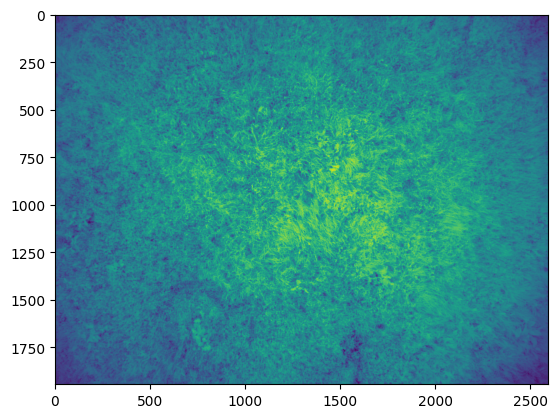

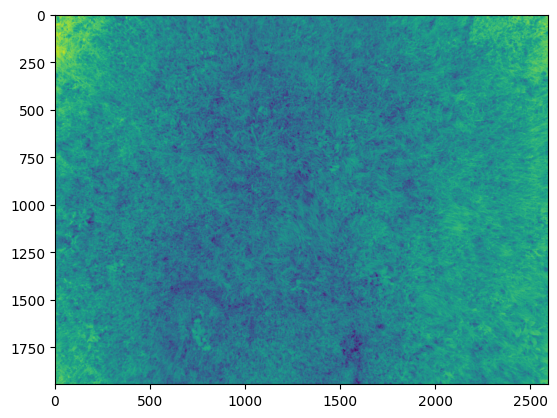

<Axes: >

In [2]:
import rasterio as rio
import os
import json
import numpy as np

def read_image(file_path):
    with rio.open(file_path) as src:
        return src.read(1), src.transform
    

# get the calibrated H matrix from the metadata
def get_md_from_json(file_path, key):
    filename_j = f"metadata/{os.path.splitext(os.path.basename(file_path))[0]}.json"
    try:
        with open(filename_j) as f:
            metadata = json.load(f)
            return metadata[key]
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

#step 1: Vignette correction
def correct_vignette(image):
    #get the vignetting data from the metadata
    k = get_md_from_json(image, 'VignettingData')

    #convert string to numpy array
    k = np.array([float(i) for i in k.split(',')]).reshape(6, 1)
    print(k)

    #read image
    data, transf = read_image(image)
    
    center_x = get_md_from_json(image, 'CalibratedOpticalCenterX')
    center_y = get_md_from_json(image, 'CalibratedOpticalCenterY')

    corrected_img = np.zeros_like(data)    

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            r = np.sqrt((j - center_x)**2 + (i - center_y)**2)
            factor = 1 + k[0] * r + k[1] * r**2 + k[2] * r**3 + k[3] * r**4 + k[4] * r**5 + k[5] * r**6
            # factor = np.polyval(k, r)
            corrected_img[i, j] = data[i, j] * factor
    return corrected_img, transf


#step3: Align images
def align_images():
    aligned_red_nir = []
    raw_red_nir = []
    file_names = glob.glob('DJI_202405031358_001/*.TIF')
    red_files = [f for f in file_names if '_MS_R.TIF' in f]
    nir_files = [f for f in file_names if '_MS_NIR.TIF' in f]

    red_files.sort()
    nir_files.sort()

    for i in range (1, 11):
        image_num = f"{i:04d}"
        #read red and nir pair of ith image
        if f"_{image_num}_MS_R.TIF" in red_files[i-1] and f"_{image_num}_MS_NIR.TIF" in nir_files[i-1]:
            red_file = red_files[i-1]
            nir_file = nir_files[i-1]

            #get metadata for both pairs
            red_Hmatrix = get_md_from_json(red_file, 'CalibratedHMatrix')
            nir_Hmatrix = get_md_from_json(nir_file, 'CalibratedHMatrix')

            #convert string to numpy array
            red_Hmatrix = np.array([float(i) for i in red_Hmatrix.split(',')]).reshape(3, 3)
            nir_Hmatrix = np.array([float(i) for i in nir_Hmatrix.split(',')]).reshape(3, 3)
            
            #read red and nir data #! use vignetting corrected data
            red_data, red_transf = correct_vignetting(red_file)#read_image(red_file)
            nir_data, nir_transf = correct_vignetting(nir_file)#read_image(nir_file)

            #align red and nir data
            aligned_red = cv.warpPerspective(red_data, red_Hmatrix, (red_data.shape[1], red_data.shape[0]))
            aligned_nir = cv.warpPerspective(nir_data, nir_Hmatrix, (nir_data.shape[1], nir_data.shape[0]))

            #append aligned red and nir data to a list
            aligned_red_nir.append((aligned_red, aligned_nir))

            #append red and nir data to a raw list
            raw_red_nir.append((red_data, nir_data))

        else:
            print("No such file exists")
    return aligned_red_nir, raw_red_nir


#test
corrected, t_corr = correct_vignette('DJI_202405031358_001/DJI_20240503140437_0006_MS_NIR.TIF')
original, t_orig = read_image('DJI_202405031358_001/DJI_20240503140437_0006_MS_NIR.TIF')

show(original, t_orig)
show(corrected, t_corr)
# show(aligned)

In [3]:
# show(original, t_orig, cmap='gray')
# show(corrected, t_corr, cmap='gray')

In [4]:
real_max_factor = np.amax(original) / np.amin(original)
print("real max factor: ", real_max_factor)
print(original.shape)
print(original[0, 0])
original_at_center = original[972, 1296]
corrected_at_center = corrected[972, 1296]
print("original at center: ", original_at_center)
print("corrected at center: ", corrected_at_center)

real max factor:  4.270557029177719
(1944, 2592)
9360
original at center:  18624
corrected at center:  18624


## step 2: Distorition correction

1296.0 972.0


/home/zed/.local/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


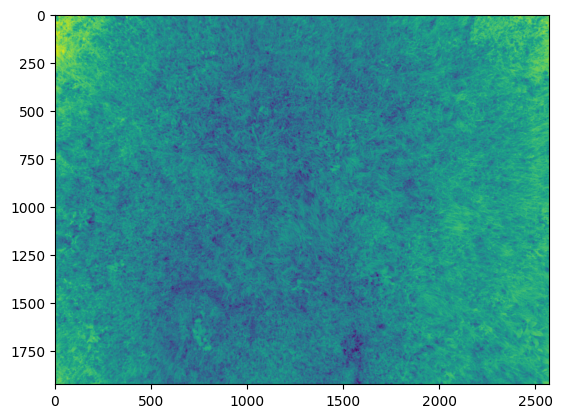

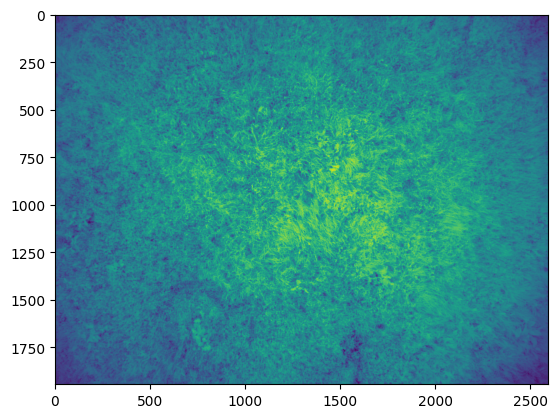

<Axes: >

In [5]:
def undistort_image(image):
    # get the dewarp data from the metadata
    dewarp_data = get_md_from_json(image, 'DewarpData')
    center_x = get_md_from_json(image, 'CalibratedOpticalCenterX')
    center_y = get_md_from_json(image, 'CalibratedOpticalCenterY')
    print(center_x, center_y)
    dewarp_data = dewarp_data.split(';')[1]
    dewarp_data = np.array([float(i) for i in dewarp_data.split(',')])

    # define the camera matrix
    fx , fy, cx, cy = dewarp_data[:4]
    mtx = np.array([
        [fx, 0, center_x + cx],
        [0, fy, center_y + cy],
        [0, 0, 1]
    ])

    # define the distortion coefficients
    k1, k2, p1, p2, k3 = dewarp_data[4:]
    dist = np.array([k1, k2, p1, p2, k3])

    # image dimension
    h, w = read_image(image)[0].shape 

    # Compute the optimal new camera matrix
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # undistort the image
    dst = cv.undistort(corrected, mtx, dist, None, newcameramtx)

    # # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

#test
dst = undistort_image('DJI_202405031358_001/DJI_20240503140437_0006_MS_NIR.TIF')
original, t_orig = read_image('DJI_202405031358_001/DJI_20240503140437_0006_MS_NIR.TIF')
show(dst)
show(original)

### Step 3: Align phase and rotation difference

[[-1.153730e-04]
 [ 1.770624e-06]
 [-4.713903e-09]
 [ 7.325446e-12]
 [-5.338319e-15]
 [ 1.490910e-18]]
(1944, 2592)


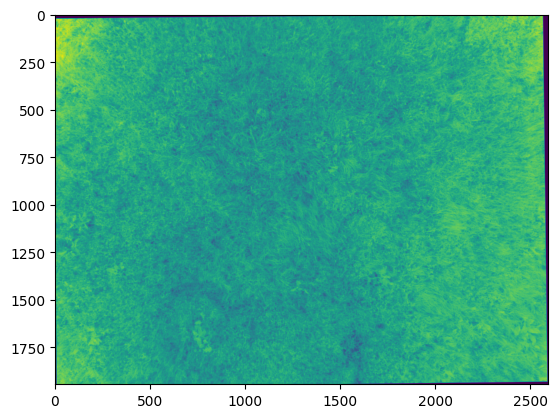

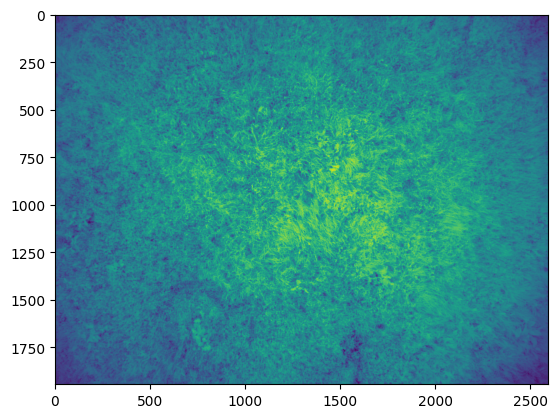

<Axes: >

In [6]:
#step3: Align images
def align_image(image_path):
    Hmatrix = get_md_from_json(image_path, 'CalibratedHMatrix')

    #convert string to numpy array
    Hmatrix = np.array([float(i) for i in Hmatrix.split(',')]).reshape(3, 3)
    
    #correct vignetting
    image_data, _ = correct_vignette(image_path)

    print(image_data.shape)
    #align image
    aligned_image = cv.warpPerspective(image_data, Hmatrix, (image_data.shape[1], image_data.shape[0]))
    return aligned_image


#test
aligned = align_image('DJI_202405031358_001/DJI_20240503140437_0006_MS_NIR.TIF')
original, _ = read_image('DJI_202405031358_001/DJI_20240503140437_0006_MS_NIR.TIF')
show(aligned)
show(original)

### Step 4: Alignment of different exposure time.

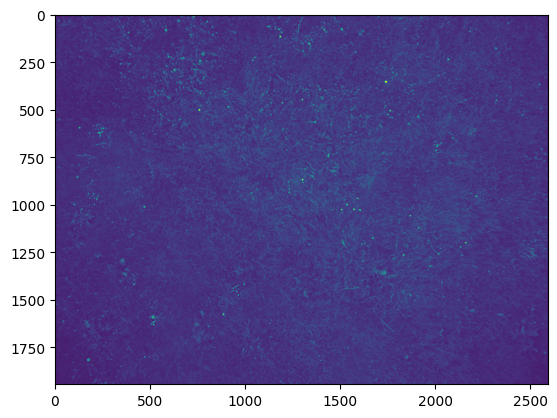

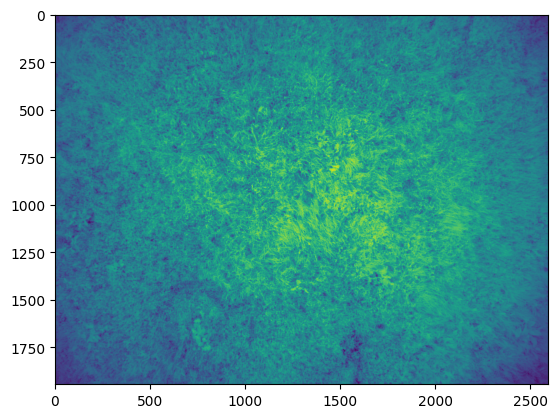

In [39]:
import cv2 as cv
import numpy as np


# step 4: align diffs due to exposure time
def align_exposure_diffs(tgt_path, src_path):
    
    # read the images
    tgt_img_data, _ = read_image(tgt_path)
    src_img_data, _ = read_image(src_path)
    
    # apply Guassian smoothing
    src_img_datas = cv.GaussianBlur(src_img_data, (5, 5), 0)
    tgt_img_datas = cv.GaussianBlur(tgt_img_data, (5, 5), 0)
 
    # apply sobel filter
    edge_img1 = cv.Sobel(src_img_datas, cv.CV_64F, 1, 0, ksize=5)
    edge_img2 = cv.Sobel(tgt_img_datas, cv.CV_64F, 1, 0, ksize=5)

    # convert to absolute values
    edge_img1 = cv.convertScaleAbs(edge_img1)
    edge_img2 = cv.convertScaleAbs(edge_img2)

    # convert to float32
    edge_img1 = np.float32(edge_img1)
    edge_img2 = np.float32(edge_img2)
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    _, warp_matrix = cv.findTransformECC(edge_img1, edge_img2, warp_matrix, cv.MOTION_AFFINE)
    aligned_img2 = cv.warpAffine(src_img_data, warp_matrix, (tgt_img_data.shape[1], tgt_img_data.shape[0]), flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP)    
    show(aligned_img2)
    show(tgt_img_data)


#test
tgt_path = 'DJI_202405031358_001/DJI_20240503140437_0006_MS_NIR.TIF'
src_path = 'DJI_202405031358_001/DJI_20240503140437_0006_MS_R.TIF'
align_exposure_diffs(tgt_path, src_path)